<a href="https://colab.research.google.com/github/ahsank/runml/blob/main/TrendTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q yahoo_fin

In [ ]:
pip install  git+https://github.com/ahsank/runml#egg=runml

In [ ]:
import runml.pipeline
from runml import pipeline,findata


In [7]:
ticker = 'SPY'
data = findata.fetch_data(ticker)
data.tail(1)

,open,high,low,close,adjclose,volume,ticker
2022-12-23,379.649994,383.059998,378.029999,382.910004,382.910004,59761100,SPY


In [66]:
tdata = data.tail(1000)
newdata = tdata
#mas = [50, 200]
mas = list(range(5, 201, 5))
for i in mas:
  df = (tdata['adjclose']
     .rolling(window=i, min_periods=1)
     .mean()
     .to_frame('ma_' + str(i)))
#          .dropna()
  newdata = df.join(newdata)
newdata['ma_0'] = newdata['adjclose']
mas.insert(0, 0)
newdata.sample(10) 

,ma_200,ma_195,ma_190,ma_185,ma_180,ma_175,ma_170,ma_165,ma_160,ma_155,...,ma_10,ma_5,open,high,low,close,adjclose,volume,ticker,ma_0
2022-10-25,406.959111,405.608089,404.717961,404.002376,402.908583,401.839895,400.961414,400.261983,399.599775,399.055591,...,367.323254,372.686627,378.790009,385.250000,378.670013,384.920013,383.160522,78846300,SPY,383.160522
2019-03-21,254.899779,254.899779,254.899779,254.899779,254.899779,254.899779,254.899779,254.899779,254.899779,254.899779,...,263.216946,265.429675,280.640015,285.179993,280.589996,284.730011,267.559052,79550400,SPY,267.559052
2020-08-11,292.072542,292.188675,292.209866,292.185438,292.097256,291.942130,291.826203,291.607007,291.222409,290.718899,...,318.196487,321.560645,336.850006,337.540009,332.010010,332.799988,320.524353,69601100,SPY,320.524353
2022-08-31,422.826644,421.883816,420.967231,420.282558,419.201442,418.187346,416.852407,415.267308,413.867220,412.561929,...,407.471387,400.674646,399.929993,401.239990,395.040009,395.179993,391.764313,76029700,SPY,391.764313
2019-11-18,274.088687,274.605639,275.043340,275.428236,275.819391,276.296998,276.651156,277.028959,277.377811,277.605913,...,293.225632,294.350690,311.529999,312.279999,311.029999,312.019989,295.989899,49228000,SPY,295.989899
2022-04-25,440.318447,440.706235,441.160835,441.470723,441.776378,442.000914,442.274365,442.403019,442.410139,442.534321,...,432.311075,430.838330,423.670013,428.690002,418.839996,428.510010,422.979095,119647700,SPY,422.979095
2020-12-23,308.058375,309.846092,312.040691,313.838830,315.609706,316.986053,318.415498,319.699175,321.152738,322.615325,...,356.600302,357.849036,368.279999,369.619995,367.220001,367.570007,356.944000,46201400,SPY,356.944000
2021-08-12,386.487504,388.207457,389.595878,390.797691,392.050801,393.208867,394.293080,395.492583,396.662699,397.854106,...,431.468085,433.247052,443.619995,445.260010,442.660004,445.109985,435.076843,38909400,SPY,435.076843
2022-09-01,422.499825,421.547912,420.684472,419.924735,418.860481,417.829209,416.400267,414.855739,413.426552,412.261127,...,404.351590,396.096558,392.890015,396.779999,390.040009,396.420013,392.993622,78740100,SPY,392.993622
2022-02-28,436.111574,436.950754,437.728829,438.492611,439.230465,440.032430,440.794960,441.431313,441.963693,442.580995,...,428.765005,423.961932,432.029999,438.200012,430.700012,436.630005,429.659515,145615000,SPY,429.659515


In [62]:
import numpy as np
import pandas as pd

In [67]:
final_price = newdata['adjclose'].iloc[-1]
buy_profit  = lambda current, ma: final_price - current if current > ma else 0
sell_profit = lambda current, ma: current - final_price if current < ma else 0
buy_dollar = lambda current, ma: current if current > ma else 0
sell_dollar = lambda current, ma: -current if current < ma else 0

fns = {'buy_profit': buy_profit,
       'sell_profit': sell_profit,
       'buy_dollar': buy_dollar,
       'sell_dollar': sell_dollar}

profit = np.zeros((len(mas), len(mas)))
mas_rows = ["ma_" + str(x) for x in mas]

for idx, i in enumerate(mas):
  for idx1, j in enumerate(mas[idx+1:], start=idx+1):
    #print (f'Comparing {i}, {j}')
    col1 = 'ma_' + str(i)
    col2 = "ma_" + str(j)
    tmpdf = newdata[['adjclose', col1, col2]].copy()
    for col, fn in fns.items():
      # since we don't have profit for last sequence, add 0's
      tmpdf[col] = list(map(fn,
                            tmpdf[col1],
                            tmpdf[col2]))

    total_buy_profit = tmpdf["buy_profit"].sum()
    total_sell_profit = tmpdf['sell_profit'].sum()
    total_buy_dollar = tmpdf['buy_dollar'].sum()
    total_sell_dollar = tmpdf['sell_dollar'].sum()
    total_return = (total_buy_profit + total_sell_profit)/(total_buy_dollar + total_sell_dollar)
    profit[idx, idx1] = total_return  

        
profit_df = pd.DataFrame(profit, index= mas_rows, columns = mas_rows)
profit_df
#newdata.tail(10)


,ma_0,ma_5,ma_10,ma_15,ma_20,ma_25,ma_30,ma_35,ma_40,ma_45,...,ma_155,ma_160,ma_165,ma_170,ma_175,ma_180,ma_185,ma_190,ma_195,ma_200
ma_0,0.0,0.113728,0.118551,0.136772,0.129330,0.129224,0.120452,0.124265,0.113546,0.110983,...,0.132471,0.130424,0.135365,0.136712,0.137530,0.133185,0.134876,0.133876,0.134518,0.134772
ma_5,0.0,0.000000,0.158682,0.143224,0.136093,0.142831,0.127469,0.123541,0.110084,0.103972,...,0.129420,0.127746,0.132615,0.131998,0.131840,0.138649,0.138932,0.137220,0.139422,0.142951
ma_10,0.0,0.000000,0.000000,0.135292,0.128822,0.133869,0.127336,0.119252,0.116008,0.107842,...,0.138216,0.138261,0.137633,0.141957,0.146076,0.143312,0.143048,0.137723,0.139756,0.138684
ma_15,0.0,0.000000,0.000000,0.000000,0.142374,0.135723,0.135679,0.125027,0.112717,0.109851,...,0.138537,0.144904,0.148958,0.148210,0.144440,0.137348,0.140705,0.143137,0.143423,0.140453
ma_20,0.0,0.000000,0.000000,0.000000,0.000000,0.128906,0.136214,0.122831,0.118628,0.114906,...,0.152478,0.158365,0.151654,0.151588,0.150209,0.148835,0.154487,0.153550,0.148751,0.145706
ma_25,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.137323,0.124635,0.113343,0.111026,...,0.159462,0.159599,0.161520,0.160750,0.161691,0.162726,0.168430,0.166457,0.162896,0.158414
ma_30,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.133008,0.113515,0.111069,...,0.158651,0.158773,0.160716,0.160926,0.162618,0.163954,0.167187,0.165360,0.164917,0.163173
ma_35,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129200,0.114809,...,0.157917,0.158873,0.160845,0.163066,0.163275,0.163162,0.163825,0.162014,0.160932,0.159196
ma_40,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123957,...,0.158130,0.158413,0.158536,0.162261,0.161072,0.159932,0.159932,0.158838,0.157084,0.157787
ma_45,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.159249,0.159249,0.158340,0.158340,0.157185,0.157185,0.156083,0.155029,0.155029,0.154025


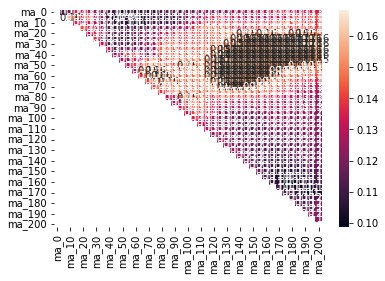

In [74]:
import seaborn as sns
%matplotlib inline
profit_df[profit_df == 0] = np.nan

sns.heatmap(profit_df,  annot=True)


0.13477183089695693